In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import display
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
def img_normalization(im_input, m0 = 0.0, var0 = 1.0):
    m = np.mean(im_input.numpy())
    var = np.var(im_input.numpy())
    #def compare(x):
    #    value = (np.sqrt((var0*(x-m)*(x-m))/var))
    #    if x > m:
    #        return (m0+value)
    #   else:
    #        return (m0-value)
    im_input = im_input.apply_(lambda x: (m0 + (np.sqrt((var0*(x-m)*(x-m))/var))) if (x>m) else (m0-(np.sqrt((var0*(x-m)*(x-m))/var))))
    return im_input     

163.90747
5922.795660831267


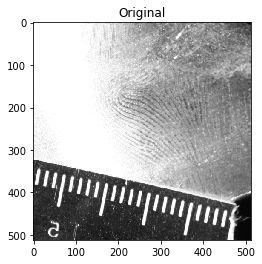

In [3]:
im = Image.open('./keras_ver/datasets/CISL24218/images/A0100003009991600022036_2.bmp')
im = torch.tensor(np.array(im),dtype=torch.float)
plt.title('Original')
plt.imshow(np.transpose(im.numpy()),cmap='gray')
print(np.mean(im.numpy()))
print((np.std(im.numpy()))**2)

In [6]:
print("media após normalização: ",np.mean(im.numpy()))
print("variancia após normalização: ",np.var(im.numpy()))

media após normalização:  -2.6077032e-08
variancia após normalização:  0.9999999


-2.6077032e-08
0.9999999


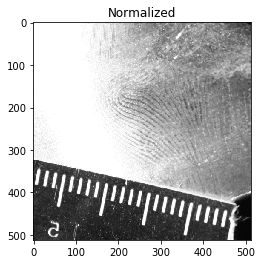

In [7]:
plt.title('Normalized')
plt.imshow(np.transpose(im.numpy()),cmap='gray')
print(np.mean(im.numpy()))
print(np.var(im.numpy()))

In [8]:
torch.FloatTensor(np.reshape(np.ones([17,17,1,1]),[1,1,17,17])).shape


torch.Size([1, 1, 17, 17])

In [12]:
def orientation(image, stride = 8, window = 17):
    assert image.shape[1] == 1, 'Images must be Grayscale'
    strides = [1,stride,stride,1]
    E = torch.FloatTensor(np.reshape(np.ones([window,window,1,1]),[1,1,window,window]))
    sobelx = torch.FloatTensor(np.reshape(np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=float), [1,1,3,3]))
    sobely = torch.FloatTensor(np.reshape(np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=float), [1,1,3,3]))
    gaussian_mask = torch.FloatTensor(np.reshape(np.array([[ 0.0000, 0.0000, 0.0002, 0.0000, 0.0000 ], [ 0.0000, 0.0113, 0.0837, 0.0113, 0.0000 ], \
                              [ 0.0002, 0.0837, 0.6187, 0.0837, 0.0002 ], [ 0.0000, 0.0113, 0.0837, 0.0113, 0.0000 ], \
                              [ 0.0000, 0.0000, 0.0002, 0.0000, 0.0000 ]]),[1,1,5,5]))
    #sobel_gradient
    Ix = F.conv2d(image,sobelx,stride=1,padding='same')
    Iy = F.conv2d(image,sobely,stride=1,padding='same')
    #elt_wise1
    Ix2 = torch.mm(Ix.view(512,512),Ix.view(512,512))
    Ix2 = Ix2.view(1,1,512,512)
    Iy2 = torch.mm(Iy.view(512,512),Iy.view(512,512))
    Iy2 = Iy2.view(1,1,512,512)    
    Ixy = torch.mm(Ix.view(512,512),Iy.view(512,512))
    Ixy = Ixy.view(1,1,512,512)
    #range_sum
    Gxx = F.conv2d(Ix2,E,stride=1,padding='same')
    Gyy = F.conv2d(Iy2,E,stride=1,padding='same')
    Gxy = F.conv2d(Ixy,E,stride=1,padding='same')
    #eltwise_2
    Gxx_Gyy = Gxx.sub(Gyy)
    theta = torch.atan2((2*Gxy),Gxx_Gyy) + np.pi        
    #gaussian_filter
    phi_x = F.conv2d(np.cos(image),gaussian_mask,stride=1,padding='same')
    phi_y = F.conv2d(np.sin(image),gaussian_mask,stride=1,padding='same')
    theta = torch.atan2(phi_y,phi_x)/2
    return theta   

In [13]:
image = im.view(1,1,512,512)
theta = orientation(image)

In [14]:
class get_tra_ori(nn.Module):
    def forward(self, input):
        return orientation(input)
tra_ori_model = get_tra_ori()

In [26]:
def get_maximum_img_size_and_names(dataset, sample_rate=None):
    if sample_rate is None:
        sample_rate = [1]*len(dataset)
    img_name, folder_name, img_size = [], [], []
    for folder, rate in zip(dataset, sample_rate):
        _, img_name_t = get_files_in_folder(folder+'images/', '.bmp')
        img_name.extend(img_name_t.tolist()*rate)
        folder_name.extend([folder]*img_name_t.shape[0]*rate)
        img_size.append(np.array(misc.imread(folder+'images/'+img_name_t[0]+'.bmp', mode='L').shape))
    img_name = np.asarray(img_name)
    folder_name = np.asarray(folder_name)
    img_size = np.max(np.asarray(img_size), axis=0)
    # let img_size % 8 == 0
    img_size = np.array(np.ceil(img_size/8)*8,dtype=np.int32)
    return img_name, folder_name, img_size

In [28]:
def sub_load_data(data, img_size, aug): 
    img_name, dataset = data
    img = misc.imread(dataset+'images/'+img_name+'.bmp', mode='L')
    seg = misc.imread(dataset+'seg_labels/'+img_name+'.png', mode='L')
    try:
        ali = misc.imread(dataset+'ori_labels/'+img_name+'.bmp', mode='L')
    except:
        ali = np.zeros_like(img)
    mnt = np.array(mnt_reader(dataset+'mnt_labels/'+img_name+'.mnt'), dtype=float)
    if any(img.shape != img_size):
        # random pad mean values to reach required shape
        if np.random.rand()<aug:
            tra = np.int32(np.random.rand(2)*(np.array(img_size)-np.array(img.shape)))
        else:
            tra = np.int32(0.5*(np.array(img_size)-np.array(img.shape)))
        img_t = np.ones(img_size)*np.mean(img)
        seg_t = np.zeros(img_size)
        ali_t = np.ones(img_size)*np.mean(ali)
        img_t[tra[0]:tra[0]+img.shape[0],tra[1]:tra[1]+img.shape[1]] = img
        seg_t[tra[0]:tra[0]+img.shape[0],tra[1]:tra[1]+img.shape[1]] = seg
        ali_t[tra[0]:tra[0]+img.shape[0],tra[1]:tra[1]+img.shape[1]] = ali
        img = img_t
        seg = seg_t
        ali = ali_t
        mnt = mnt+np.array([tra[1],tra[0],0]) 
    if np.random.rand()<aug:
        # random rotation [0 - 360] & translation img_size / 4
        rot = np.random.rand() * 360
        tra = (np.random.rand(2)-0.5) / 2 * img_size 
        img = ndimage.rotate(img, rot, reshape=False, mode='reflect')
        img = ndimage.shift(img, tra, mode='reflect')
        seg = ndimage.rotate(seg, rot, reshape=False, mode='constant')
        seg = ndimage.shift(seg, tra, mode='constant')
        ali = ndimage.rotate(ali, rot, reshape=False, mode='reflect')
        ali = ndimage.shift(ali, tra, mode='reflect') 
        mnt_r = point_rot(mnt[:, :2], rot/180*np.pi, img.shape, img.shape)  
        mnt = np.column_stack((mnt_r+tra[[1, 0]], mnt[:, 2]-rot/180*np.pi))
    # only keep mnt that stay in pic & not on border
    mnt = mnt[(8<=mnt[:,0])*(mnt[:,0]<img_size[1]-8)*(8<=mnt[:, 1])*(mnt[:,1]<img_size[0]-8), :]
    return img, seg, ali, mnt   

In [29]:
def load_data(dataset, tra_ori_model, rand=False, aug=0.0, batch_size=1, sample_rate=None):
    if type(dataset[0]) == str:
        img_name, folder_name, img_size = get_maximum_img_size_and_names(dataset, sample_rate)
    else:
        img_name, folder_name, img_size = dataset
    if rand:
        rand_idx = np.arange(len(img_name))
        np.random.shuffle(rand_idx)
        img_name = img_name[rand_idx]
        folder_name = folder_name[rand_idx]
        
    if batch_size > 1 and use_multiprocessing==True:
        p = Pool(batch_size)        
    p_sub_load_data = partial(sub_load_data, img_size=img_size, aug=aug)
    for i in xrange(0,len(img_name), batch_size):
        have_alignment = np.ones([batch_size, 1, 1, 1])
        image = np.zeros((batch_size, img_size[0], img_size[1], 1))
        segment = np.zeros((batch_size, img_size[0], img_size[1], 1))
        alignment = np.zeros((batch_size, img_size[0], img_size[1], 1))
        minutiae_w = np.zeros((batch_size, img_size[0]/8, img_size[1]/8, 1))-1
        minutiae_h = np.zeros((batch_size, img_size[0]/8, img_size[1]/8, 1))-1
        minutiae_o = np.zeros((batch_size, img_size[0]/8, img_size[1]/8, 1))-1
        batch_name = [img_name[(i+j)%len(img_name)] for j in xrange(batch_size)]
        batch_f_name = [folder_name[(i+j)%len(img_name)] for j in xrange(batch_size)]
        if batch_size > 1 and use_multiprocessing==True:    
            results = p.map(p_sub_load_data, zip(batch_name, batch_f_name))
        else:
            results = map(p_sub_load_data, zip(batch_name, batch_f_name))
        for j in xrange(batch_size):
            img, seg, ali, mnt = results[j]
            if np.sum(ali) == 0:
                have_alignment[j, 0, 0, 0] = 0
            image[j, :, :, 0] = img / 255.0
            segment[j, :, :, 0] = seg / 255.0
            alignment[j, :, :, 0] = ali / 255.0
            minutiae_w[j, (mnt[:, 1]/8).astype(int), (mnt[:, 0]/8).astype(int), 0] = mnt[:, 0] % 8
            minutiae_h[j, (mnt[:, 1]/8).astype(int), (mnt[:, 0]/8).astype(int), 0] = mnt[:, 1] % 8
            minutiae_o[j, (mnt[:, 1]/8).astype(int), (mnt[:, 0]/8).astype(int), 0] = mnt[:, 2]
        # get seg
        label_seg = segment[:, ::8, ::8, :]
        label_seg[label_seg>0] = 1
        label_seg[label_seg<=0] = 0
        minutiae_seg = (minutiae_o!=-1).astype(float)
        # get ori & mnt
        orientation = tra_ori_model(alignment)        
        orientation = orientation/np.pi*180+90
        orientation[orientation>=180.0] = 0.0 # orientation [0, 180)
        minutiae_o = minutiae_o/np.pi*180+90 # [90, 450)
        minutiae_o[minutiae_o>360] = minutiae_o[minutiae_o>360]-360 # to current coordinate system [0, 360)
        minutiae_ori_o = np.copy(minutiae_o) # copy one
        minutiae_ori_o[minutiae_ori_o>=180] = minutiae_ori_o[minutiae_ori_o>=180]-180 # for strong ori label [0,180)      
        # ori 2 gaussian
        gaussian_pdf = signal.gaussian(361, 3)
        y = np.reshape(np.arange(1, 180, 2), [1,1,1,-1])
        delta = np.array(np.abs(orientation - y), dtype=int)
        delta = np.minimum(delta, 180-delta)+180
        label_ori = gaussian_pdf[delta]
        # ori_o 2 gaussian
        delta = np.array(np.abs(minutiae_ori_o - y), dtype=int)
        delta = np.minimum(delta, 180-delta)+180
        label_ori_o = gaussian_pdf[delta] 
        # mnt_o 2 gaussian
        y = np.reshape(np.arange(1, 360, 2), [1,1,1,-1])
        delta = np.array(np.abs(minutiae_o - y), dtype=int)  
        delta = np.minimum(delta, 360-delta)+180
        label_mnt_o = gaussian_pdf[delta]         
        # w 2 gaussian
        gaussian_pdf = signal.gaussian(17, 2)
        y = np.reshape(np.arange(0, 8), [1,1,1,-1])
        delta = (minutiae_w-y+8).astype(int)
        label_mnt_w = gaussian_pdf[delta]
        # h 2 gaussian
        delta = (minutiae_h-y+8).astype(int)
        label_mnt_h = gaussian_pdf[delta]
        # mnt cls label -1:neg, 0:no care, 1:pos
        label_mnt_s = np.copy(minutiae_seg)
        label_mnt_s[label_mnt_s==0] = -1 # neg to -1
        label_mnt_s = (label_mnt_s+ndimage.maximum_filter(label_mnt_s, size=(1,3,3,1)))/2 # around 3*3 pos -> 0
        # apply segmentation
        label_ori = label_ori * label_seg * have_alignment
        label_ori_o = label_ori_o * minutiae_seg
        label_mnt_o = label_mnt_o * minutiae_seg
        label_mnt_w = label_mnt_w * minutiae_seg
        label_mnt_h = label_mnt_h * minutiae_seg
        yield image, label_ori, label_ori_o, label_seg, label_mnt_w, label_mnt_h, label_mnt_o, label_mnt_s, batch_name
    if batch_size > 1 and use_multiprocessing==True:
        p.close()
        p.join()
    return

In [30]:
def merge_mul(x):
    return reduce(lambda x,y:x*y, x)
def merge_sum(x):
    return reduce(lambda x,y:x+y, x)

In [32]:
def reduce_sum(x):
    return K.sum(x,axis=-1,keepdims=True) 
def merge_concat(x):
    return torch.concat(x,3)
EPSILON = 1e-7
def select_max(x):
    x = x / (torch.sum(x,dim=-1,keepdim=True) + EPSILON)
    x = x.apply_(lambda x: (x) if (x>0.999) else (torch.zeros_like(x)))
    x = x / (torch.sum(x,dim=-1,keepdim=True) + EPSILON)
    return x  

In [ ]:
def conv_bn(bottom, w_size, name, strides=(1,1), dilation_rate=(1,1)):
    top = Conv2D(w_size[0], (w_size[1],w_size[2]),
        kernel_regularizer=l2(5e-5),
        padding='same', 
        strides=strides,
        dilation_rate=dilation_rate,
        name='conv-'+name)(bottom)
    top = BatchNormalization(name='bn-'+name)(top)
    return top
def conv_bn_prelu(bottom, w_size, name, strides=(1,1), dilation_rate=(1,1)):
    if dilation_rate == (1,1):
        conv_type = 'conv'
    else:
        conv_type = 'atrousconv'
    top = Conv2D(w_size[0], (w_size[1],w_size[2]),
        kernel_regularizer=l2(5e-5),
        padding='same', 
        strides=strides,
        dilation_rate=dilation_rate,
        name=conv_type+name)(bottom)
    top = BatchNormalization(name='bn-'+name)(top)
    top=PReLU(alpha_initializer='zero', shared_axes=[1,2], name='prelu-'+name)(top)
    return top